# Introduction

YouTube is the biggest video-sharing platform in the world. People share videos on YouTube, hope their videos can go viral, and even make money out of it. So, **what attributes do those viral videos have?**   

In this Notebook, I will be analyzing real historical data of trending YouTube videos, trying to find something in common for these videos and why they are viral. I will try to answer three main questions through this analysis:
- What types of videos are more likely to be trending?
- Do descriptions or tags matter?
- Days Between Publishing and Trending

I'm going to use the data from the Trending YouTube Video Statistics from Kaggle.

# Business Understanding

This analysis aims to provide practical and useful data-based tips for YouTubers to make videos that are more likely to be viewed and liked.

## Import Modules and Load the Dataset

In [1]:
import pandas as pd # data processing
import numpy as np # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
from datetime import datetime
import os 

In [2]:
# import the csv and the json files
df_category = pd.read_json("US_category_id.json")
df_videos = pd.read_csv("USvideos.csv")
print(df_videos.shape)

(40949, 16)


# Data Understanding and Preparing

In [3]:
# first five rows of the dataset
df_videos.head()


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


## Add Useful Columns

In [3]:
# add category name into the dataset
cat_id =[]
cat_name = []
# get category id and category name from df_category
for index,row in df_category.iterrows():
    x = row['items']
    cat_id.append(x['id'])
    cat_name.append(x['snippet']['title'])
# create a DataFrame for category id and names
category = pd.DataFrame(zip(cat_id, cat_name),columns=['category_id', 'category'])
category['category_id'] = category['category_id'].astype('int64')
# merge the category DataFrame with the df_videos using category_id
df = pd.merge(df_videos, category, on = 'category_id', how = 'inner')

In [4]:
# change trending_date to datetime
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
# add publish_date
df['publish_date'] = df['publish_time'].replace(r'T.*', '', regex=True)
df['publish_date'] = pd.to_datetime(df.publish_date, format='%Y-%m-%d')
# add trending_delta (days between publishing and trending)
df['trending_delta'] = (df['trending_date'] - df['publish_date']).dt.days

In [5]:
# add number of tags
df['n_tags'] = df['tags'].str.split('|').str.len()

In [6]:
# add length of description
df['len_description'] = df['description'].str.split().str.len()
'''If values are missing in the field descrption, 
   then the len_description is 0'''
df['len_description'] = df['len_description'].fillna(0)
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category,publish_date,trending_delta,n_tags,len_description
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,...,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,2017-11-13,1,1,130.0
1,0mlNzVSJrT0,2017-11-14,Me-O Cats Commercial,Nobrand,22,2017-04-21T06:47:32.000Z,"cute|""cats""|""thai""|""eggs""",98966,2486,184,...,https://i.ytimg.com/vi/0mlNzVSJrT0/default.jpg,False,False,False,Kittens come out of the eggs in a Thai commerc...,People & Blogs,2017-04-21,207,4,16.0
2,STI2fI7sKMo,2017-11-14,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,22,2017-11-11T15:00:03.000Z,"shawn johnson|""andrew east""|""shawn east""|""shaw...",321053,4451,1772,...,https://i.ytimg.com/vi/STI2fI7sKMo/default.jpg,False,False,False,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs,2017-11-11,3,44,57.0
3,KODzih-pYlU,2017-11-14,BLIND(folded) CAKE DECORATING CONTEST (with Mo...,Grace Helbig,22,2017-11-11T18:08:04.000Z,"itsgrace|""funny""|""comedy""|""vlog""|""grace""|""helb...",197062,7250,217,...,https://i.ytimg.com/vi/KODzih-pYlU/default.jpg,False,False,False,Molly is an god damn amazing human and she cha...,People & Blogs,2017-11-11,3,12,78.0
4,8mhTWqWlQzU,2017-11-14,Wearing Online Dollar Store Makeup For A Week,Safiya Nygaard,22,2017-11-11T01:19:33.000Z,wearing online dollar store makeup for a week|...,2744430,115426,1110,...,https://i.ytimg.com/vi/8mhTWqWlQzU/default.jpg,False,False,False,I found this online dollar store called ShopMi...,People & Blogs,2017-11-11,3,25,75.0


In [7]:
# check data types
df.dtypes

video_id                          object
trending_date             datetime64[ns]
title                             object
channel_title                     object
category_id                        int64
publish_time                      object
tags                              object
views                              int64
likes                              int64
dislikes                           int64
comment_count                      int64
thumbnail_link                    object
comments_disabled                   bool
ratings_disabled                    bool
video_error_or_removed              bool
description                       object
category                          object
publish_date              datetime64[ns]
trending_delta                     int64
n_tags                             int64
len_description                  float64
dtype: object

In [8]:
# check missing values
df.isnull().mean()

video_id                  0.00000
trending_date             0.00000
title                     0.00000
channel_title             0.00000
category_id               0.00000
publish_time              0.00000
tags                      0.00000
views                     0.00000
likes                     0.00000
dislikes                  0.00000
comment_count             0.00000
thumbnail_link            0.00000
comments_disabled         0.00000
ratings_disabled          0.00000
video_error_or_removed    0.00000
description               0.01392
category                  0.00000
publish_date              0.00000
trending_delta            0.00000
n_tags                    0.00000
len_description           0.00000
dtype: float64

Only the field description has missing values, which doesn't hurt

In [9]:
# check trending date range
# chage the trending_date to datetime type
df['trending_date'] = pd.to_datetime(df.trending_date, format='%y.%d.%m')
print(f'The trending date range is from {str(df["trending_date"].min()).rstrip(" 00:00:00")} to {str(df["trending_date"].max()).rstrip(" 00:00:00")}.')

The trending date range is from 2017-11-14 to 2018-06-14.


In [10]:
print(df.shape)
df_desc = df[df.columns.difference(['category_id'])].describe().round(2)

# export the descrone dataframe as a png
import dataframe_image as dfi

#dfi.export(df_desc, 'img/mytable.png')

(40949, 21)


# Key Questions and Visualization

In [16]:
def barplot_style():
    '''Style for barplots, no parameters'''
    sns.despine(offset=10, trim=True, left = True)
    plt.tight_layout()

def dist_style():
    '''Style for distribution plots, no parameters'''
    sns.set_style("whitegrid")
    sns.despine()
    plt.tight_layout()


## What types of videos are more likely to be trending?

### Popular Channels

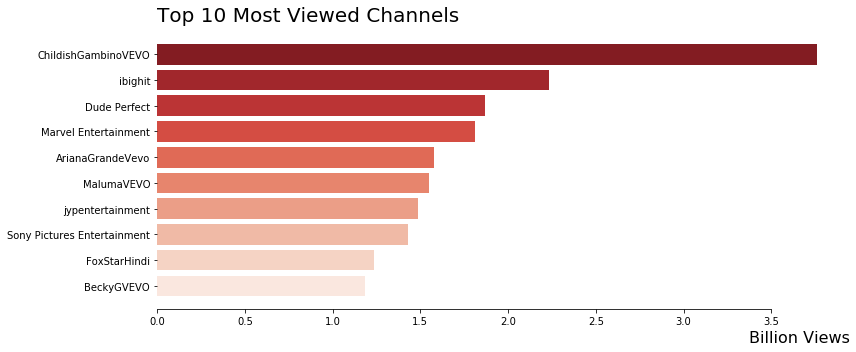

In [12]:
pop_channels = df[['channel_title', 'views']].groupby('channel_title').sum().reset_index().sort_values('views', ascending=False).head(10)
pop_channels['views'] = pop_channels['views']/1000000000
# plot barplot
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.barplot(x='views', y='channel_title', data=pop_channels, palette = 'Reds_r')
plt.xlabel('Billion Views', fontsize=16, horizontalalignment='right', position = (1,25))
plt.ylabel('', fontsize=16)
plt.title('Top 10 Most Viewed Channels', fontsize=20, loc='left', pad=20)

barplot_style()

#plt.savefig('img/pop_channels.pdf')

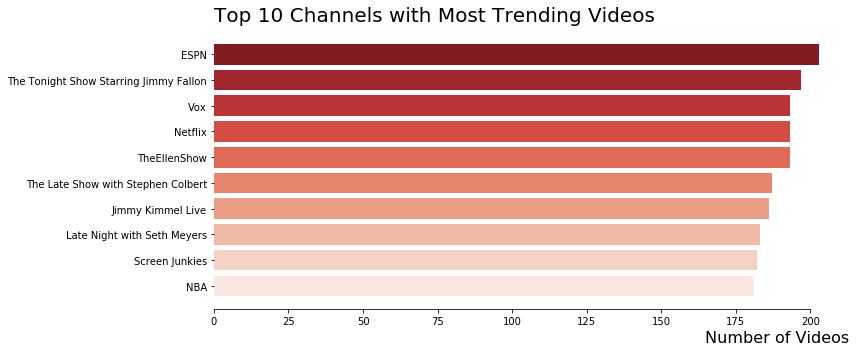

In [13]:
# create a dataframe with top 10 channels with the most trending videos
prdct_channels = df.groupby('channel_title').size().reset_index(name='n_videos').sort_values('n_videos', ascending=False).head(10)
# plot barplot
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.barplot(x='n_videos', y='channel_title', data=prdct_channels, palette = 'Reds_r')
plt.xlabel('Number of Videos', fontsize=16, horizontalalignment='right', position = (1,25))
plt.ylabel('', fontsize=16)
plt.title('Top 10 Channels with Most Trending Videos', fontsize=20, loc='left', pad=20)

barplot_style()

#plt.savefig('img/prdct_channels.pdf')


### Popular Categories

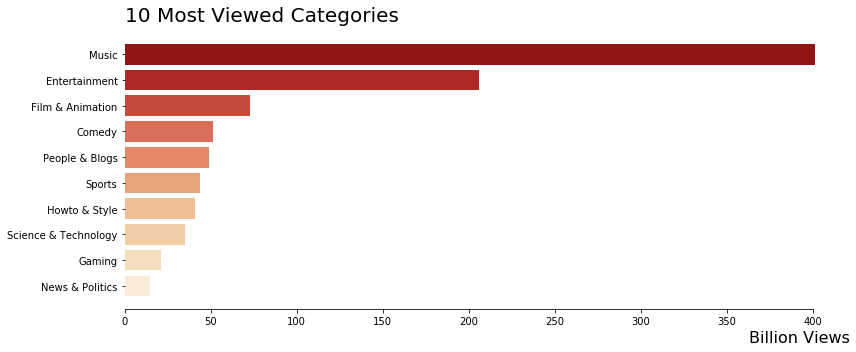

In [14]:
# create a dataframe with top 30 most popular channels
pop_categories = df[['category', 'views']].groupby('category').sum().reset_index().sort_values('views', ascending=False).head(10)
pop_categories['views'] = pop_categories['views']/100000000
# plot barplot
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.barplot(x='views', y='category', data=pop_categories, palette = 'OrRd_r')
plt.xlabel('Billion Views', fontsize=16, horizontalalignment='right', position = (1,25))
plt.ylabel('', fontsize=16)
plt.title('10 Most Viewed Categories ', fontsize=20, loc='left', pad=20)

barplot_style()

#plt.savefig('img/pop_categories.pdf')

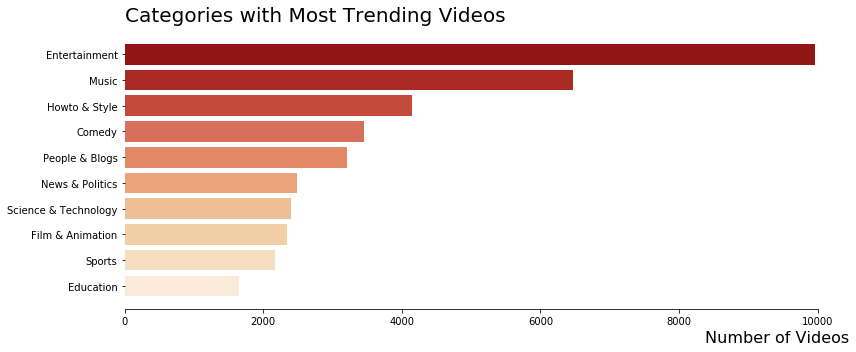

In [15]:
# create a dataframe with top 30 most popular channels
pop_categories = df.groupby('category').size().reset_index(name='n_videos').sort_values('n_videos', ascending=False).head(10)
# plot barplot
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.barplot(x='n_videos', y='category', data=pop_categories, palette = 'OrRd_r')
plt.xlabel('Number of Videos', fontsize=16, horizontalalignment='right', position = (1,25))
plt.ylabel('', fontsize=16)
plt.title('Categories with Most Trending Videos', fontsize=20, loc='left', pad=20)

barplot_style()

#plt.savefig('img/prdct_categories.pdf')

## Do descriptioins or tags matter?

### Number of tags

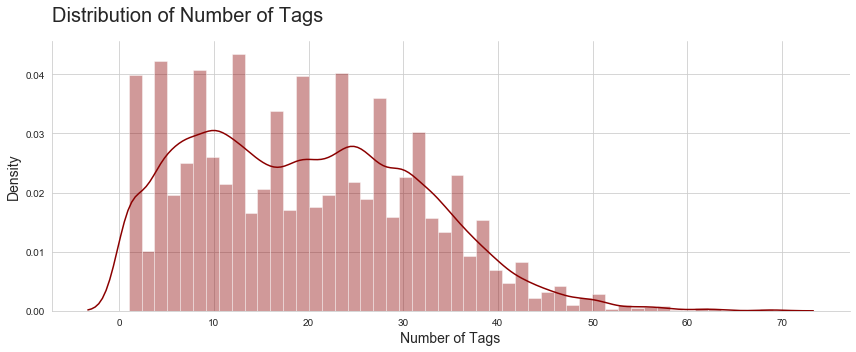

In [19]:
# distribution plot of number of tags
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.distplot(df['n_tags'], color="darkred")
plt.xlabel('Number of Tags', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Distribution of Number of Tags', fontsize=20, loc='left', pad=20)

dist_style()

#plt.savefig('img/tags_dist.pdf')

In [17]:
# create a list for all the tags
tags_list = []
for item in df['tags'].str.split('|'):
    for tag in item:
        tags_list.append(tag)
print(f'The number of all the tags is {len(tags_list)}.')
print(f'The number of unique tags is {len(set(tags_list))}.')

The number of all the tags is 808183.
The number of unique tags is 58123.


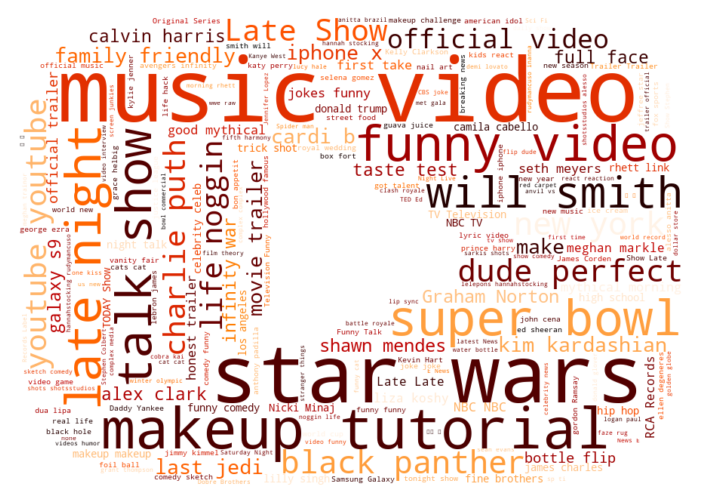

In [18]:
# import modules for word cloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# introduce a mask
mask = np.array(Image.open("img/logo2.png").convert('RGB'))
# generate a word cloud image for tags
wordcloud = WordCloud(width=1600, height=900, background_color='white', colormap='gist_heat', mask=mask, random_state=42)
wordcloud.generate(" ".join(tags_list))
#image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(16,9))
#plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show

# save the image in the img folder:
#os.mkdir('img')
wordcloud.to_file("img/wordcloud_review.png")

### Length of Description

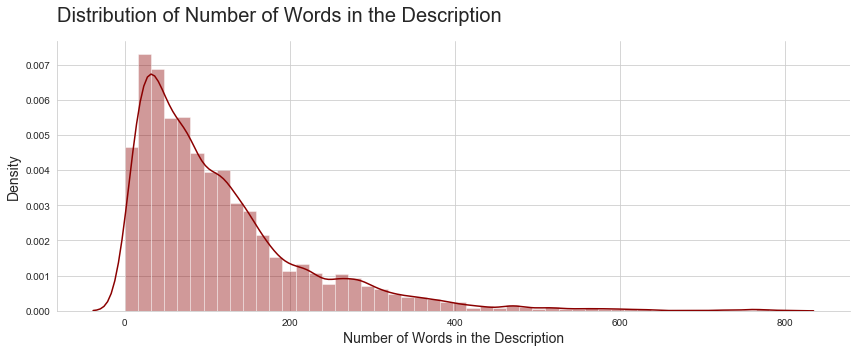

In [18]:
# distribution plot of number of words in description
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.distplot(df['len_description'], color="darkred")
plt.xlabel('Number of Words in the Description', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Distribution of Number of Words in the Description', fontsize=20, loc='left', pad=20)

dist_style()

# plt.savefig('img/len_description_dist.pdf')

## Days Between Publishing and Trending

In [20]:
print(f'The longest gap between publishing and trending of a video is {df["trending_delta"].max()} days, which is {round(df["trending_delta"].max()/365, 1)} years.')

The longest gap between publishing and trending of a video is 4215 days, which is 11.5 years.


In [21]:
df[df["trending_delta"]==4215]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category,publish_date,trending_delta,n_tags,len_description
7054,MJO3FmmFuh4,2018-02-05,Budweiser - Original Whazzup? ad,dannotv,24,2006-07-23T08:24:11.000Z,"Budweiser|""Bud""|""Whazzup""|""ad""",258506,459,152,...,https://i.ytimg.com/vi/MJO3FmmFuh4/default.jpg,False,False,False,"Original Whazzup ad - however, there is a litt...",Entertainment,2006-07-23,4215,4,13.0


In [22]:
print(f'There are {df[df["trending_delta"]==0].shape[0]} videos that went viral the same day as published')

121

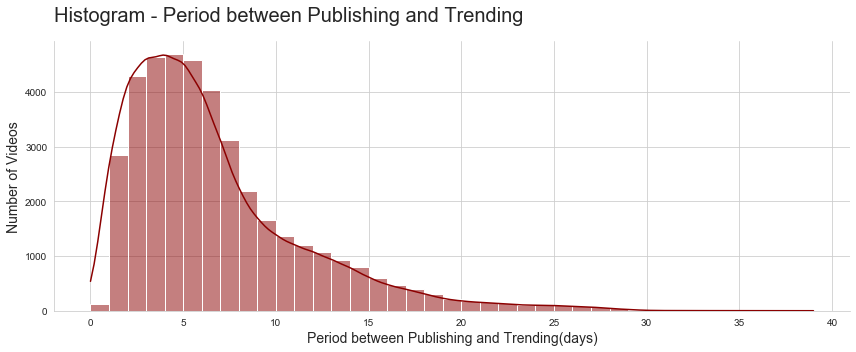

In [20]:
# distribution plot of trending_delta
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.histplot(df["trending_delta"][df['trending_delta']<40],binwidth=1, kde = True, color="darkred")
plt.xlabel('Period between Publishing and Trending(days)', fontsize=14)
plt.ylabel('Number of Videos', fontsize=14)
plt.title('Histogram - Period between Publishing and Trending', fontsize=20, loc='left', pad=20)

dist_style()

# plt.savefig('img/hist_delta.pdf')


In [47]:
df[df["trending_delta"]>365].shape[0]/df.shape[0]

0.005421377811423966

## Correlation between numerical columns

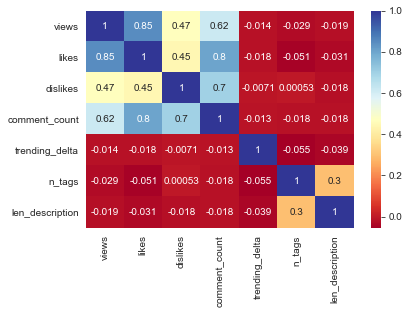

In [457]:
fig, ax = plt.subplots()
sns.heatmap(df[['views', 'likes', 'dislikes', 'comment_count', 'trending_delta', 'n_tags', 'len_description']].corr(), cmap='RdYlBu', annot=True, ax=ax)


### -- Create a Word Cloud for the Blog

In [73]:
# create a list for channel title
channels = df['channel_title'].to_list()

print(f'The number of all the tags is {len(channels)}.')
print(f'The number of unique tags is {len(set(channels))}.')

The number of all the tags is 40949.
The number of unique tags is 2207.


<function matplotlib.pyplot.show(*args, **kw)>

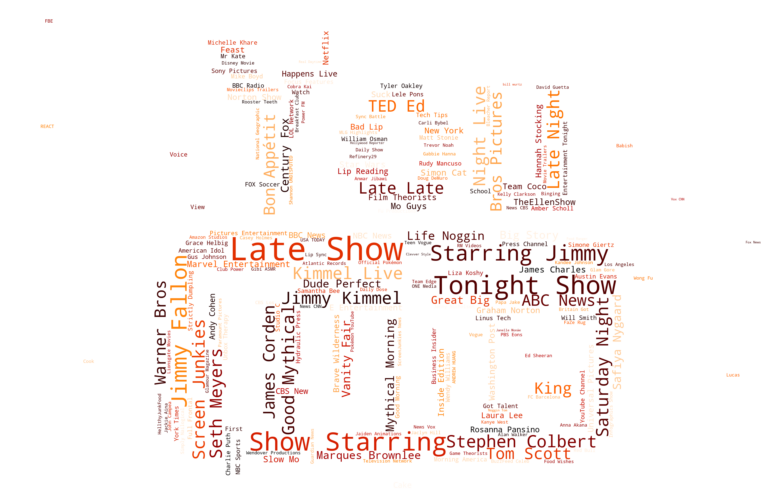

In [104]:
# create a word cloud for channels
# introduce a mask
mask = np.array(Image.open("img/logo3.png").convert('RGB'))
# generate a word cloud image for tags
wordcloud = WordCloud(width=1600, height=900, background_color='white', colormap='gist_heat', mask=mask, random_state=42)
wordcloud.generate(" ".join(channels))
#image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(16,9))
#plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show

# save the image in the img folder:
#os.mkdir('img')
#wordcloud.to_file("img/wordcloud_channels.png")